# Approximate q-learning

In this notebook you will teach a lasagne neural network to do Q-learning.

__Frameworks__ - we'll accept this homework in any deep learning framework. For example, it translates to TensorFlow almost line-to-line. However, we recommend you to stick to theano/lasagne unless you're certain about your skills in the framework of your choice.

In [1]:
#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

Starting virtual X frame buffer: Xvfb../xvfb: line 8: start-stop-daemon: command not found
.
env: DISPLAY=:1


In [2]:
import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

[2017-05-05 10:13:12,790] Making new env: CartPole-v0


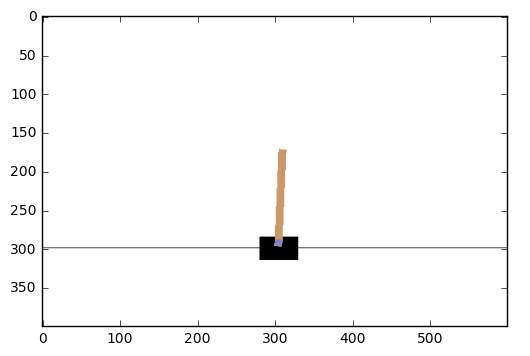

In [3]:
env = gym.make("CartPole-v0")
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Approximate (deep) Q-learning: building the network

In this section we will build and train naive Q-learning with theano/lasagne

First step is initializing input variables

In [4]:
import theano
import theano.tensor as T

# create input variables. We'll support multiple states at once
current_states = T.matrix("states[batch,units]")
actions = T.ivector("action_ids[batch]")
rewards = T.vector("rewards[batch]")
next_states = T.matrix("next states[batch,units]")
is_end = T.ivector("vector[batch] where 1 means that session just ended")

In [6]:
import lasagne
from lasagne.layers import *
from lasagne.nonlinearities import *

# neural network
l_states = InputLayer((None,)+state_dim)
l_nn = DenseLayer(l_states, 128, nonlinearity=elu)
l_nn = DenseLayer(l_nn, 128, nonlinearity=elu)
l_qvalues = DenseLayer(l_nn, n_actions, nonlinearity=None)

#### Predicting Q-values for `current_states`

In [7]:
#get q-values for ALL actions in current_states
predicted_qvalues = get_output(l_qvalues,{l_states:current_states})

In [8]:
#compiling agent's "GetQValues" function
#get_qvalues = <compile a function that takes current_states and returns predicted_qvalues>
get_qvalues = theano.function([current_states], predicted_qvalues)

In [9]:
#select q-values for chosen actions
predicted_qvalues_for_actions = predicted_qvalues[T.arange(actions.shape[0]),actions]

#### Loss function and `update`
Here we write a function similar to `agent.update`.

In [11]:
#predict q-values for next states
predicted_next_qvalues = get_output(l_qvalues, {l_states: next_states})

#Computing target q-values under 
gamma = 0.99

#target_qvalues_for_actions = <target Q-values using rewards and predicted_next_qvalues>
target_qvalues_for_actions = rewards + gamma * predicted_next_qvalues.max(-1)

#zero-out q-values at the end
target_qvalues_for_actions = (1-is_end)*target_qvalues_for_actions

#don't compute gradient over target q-values (consider constant)
target_qvalues_for_actions = theano.gradient.disconnected_grad(target_qvalues_for_actions)

In [12]:
# mean squared error loss function between target_qvalues_for_actions and predicted_qvalues_for_actions
loss = lasagne.objectives.squared_error(target_qvalues_for_actions, predicted_qvalues_for_actions).mean()

In [13]:
# all network weights
all_weights = get_all_params(l_qvalues, trainable=True)

# network updates. Note the small learning rate (for stability)
updates = lasagne.updates.sgd(loss, all_weights, learning_rate=1e-4)

In [14]:
#Training function that resembles agent.update(state,action,reward,next_state) 
#with 1 more argument meaning is_end
train_step = theano.function([current_states,actions,rewards,next_states,is_end],
                             updates=updates)

### Playing the game

In [16]:
epsilon = 0.25 #initial epsilon

def generate_session(t_max=1000):
    """play env with approximate q-learning agent and train it at the same time"""
    
    total_reward = 0
    s = env.reset()
    
    for t in range(t_max):
        
        #get action q-values from the network
        q_values = get_qvalues([s])[0] 
        
        # sample action with epsilon-greedy strategy
        if (np.random.rand() < epsilon):
            a = np.random.randint(len(q_values)) # random action
        else:
            a = np.argmax(q_values) # best action
        
        new_s,r,done,info = env.step(a)
        
        #train agent one step. Note that we use one-element arrays instead of scalars 
        #because that's what function accepts.
        train_step([s],[a],[r],[new_s],[done])
        
        total_reward+=r
        
        s = new_s
        if done: break
            
    return total_reward
        

In [ ]:
for i in range(100):
    
    rewards = [generate_session() for _ in range(100)] #generate new sessions
    
    epsilon*=0.95
    
    print ("mean reward:%.3f\tepsilon:%.5f"%(np.mean(rewards),epsilon))
    
    plt.cl
    plt.plot(rewards)
    plt.show()

    if np.mean(rewards) > 300:
        print ("You Win!")
        break
        
    assert epsilon!=0, "Please explore environment"

mean reward:11.420	epsilon:0.23750
mean reward:10.560	epsilon:0.22562
mean reward:10.780	epsilon:0.21434
mean reward:10.600	epsilon:0.20363
mean reward:10.200	epsilon:0.19345
mean reward:10.420	epsilon:0.18377
mean reward:10.510	epsilon:0.17458
mean reward:10.720	epsilon:0.16586
mean reward:13.460	epsilon:0.15756
mean reward:13.900	epsilon:0.14968
mean reward:17.290	epsilon:0.14220
mean reward:17.910	epsilon:0.13509
mean reward:21.180	epsilon:0.12834
mean reward:28.370	epsilon:0.12192
mean reward:29.690	epsilon:0.11582
mean reward:25.420	epsilon:0.11003
mean reward:26.340	epsilon:0.10453
mean reward:32.530	epsilon:0.09930
mean reward:35.540	epsilon:0.09434
mean reward:42.080	epsilon:0.08962
mean reward:47.030	epsilon:0.08514
mean reward:53.400	epsilon:0.08088
mean reward:74.570	epsilon:0.07684
mean reward:141.420	epsilon:0.07300
mean reward:169.240	epsilon:0.06935
mean reward:143.780	epsilon:0.06588
mean reward:118.210	epsilon:0.06259
mean reward:245.060	epsilon:0.05946
mean reward:84.

### Video

In [ ]:
epsilon=0 #Don't forget to reset epsilon back to initial value if you want to go on training

In [ ]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(env,directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]
env.close()
#unwrap 
env = env.env.env
#upload to gym
#gym.upload("./videos/",api_key="<your_api_key>") #you'll need me later

#Warning! If you keep seeing error that reads something like"DoubleWrapError",
#run env=gym.make("CartPole-v0");env.reset();

In [ ]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

### Homework

Two paths lie ahead of you, and which one to take is a rightfull choice of yours.

* __[recommended]__ Go deeper. Return to seminar1 and get 99% accuracy on MNIST
* __[alternative]__ Try approximate expected-value SARSA and other algorithms and compare it with q-learning 
  * +3 points for EV-SARSA and comparison to Q-learning
  * +2 per additional algorithm
* __[alternative hard]__ Pick ```<your favourite env>``` and solve it, using NN.
 * LunarLander, MountainCar or Breakout (from week1 bonus)
 * LunarLander should get at least +100
 * MountainCar should get at least -200
 * You will need to somehow stabilize learning
   


In [7]:
a = 1 if False else 2

In [8]:
a

2